<img src="https://dbmi.hms.harvard.edu/sites/g/files/mcu781/files/hero-images/HMS_DBMI_Logo.svg" width= "550px">

# PIC-SURE API use-case: Phenome-Wide analysis on COPDgene data

## PIC-SURE python API 
### What is PIC-SURE? 

<img src="./img/PIC-SURE_logo.png" width= "360px">

PIC-SURE is an API (Application Programming Interface) specifically suited to query databases containing genomics and phenotypical data. It is directly aimed to investigators scientist conducting epidemiological research, enabling them to retrieve the data in a data-analysis ready format.


### Why PIC-SURE? 
Databases exposed through PIC-SURE API encompass a wide heterogeneity of architecture and data organization underneath. PIC-SURE hide this complexity and expose the different data in the same format, allowing for data-scientist and clinical researchers to focus on the analysis and medical insights, thus unburdening the complexity of integrating clinical and genomics data, and easing the process of reproducible sciences.

### More about
PIC-SURE stands for Patient-centered Information Commons: Standardized Unification of Research Elements. The API is available in two different programming languages, python and R, allowing investigators two query databases in the same way using any of those languages.

PIC-SURE is actually larger project from which PIC-SURE R/python API is only a brick. Among those other components, PIC-SURE offers also a graphical user interface, allowing scientist to get knowledge about variables and data for a specific data source, and also another tool (**integrating reference**) to get quick data analysis through a GUI.

The Python/R API are actively developed by the Avillach-Lab at Harvard Medical School.

GitHub repo:
* https://github.com/hms-dbmi/pic-sure-python-adapter-hpds
* https://github.com/hms-dbmi/pic-sure-python-client



## Phenome-Wide Association Studies (PheWAS)

### What is a PheWAS analysis?
PheWAS analysis is basically testing the association of an individual trait (i.e. a genomic variant in most of the cases, but not exclusively) against a wide-variety of phenotypes. It is frequently used in the genomics field, sometimes in association with GEWAS analyzes (invert process, i.e. testing association of a phenotype against multiple genetic variants).

References:
- [*Denny et al.*, 2010](https://academic.oup.com/bioinformatics/article/26/9/1205/201211)
- [*Denny et al.*, 2017](https://www.annualreviews.org/doi/abs/10.1146/annurev-genom-090314-024956)

## COPDGene data

COPDGene is a case-control study that focus on COPD, and that comprise linked and clinical data. It's one of the database that is integrated in the BioData Catalyst alongside other projects.
Although genomics data are not yet available through PIC-SURE API, it is well-suited for a use case because of the fact that it does provide a specific trait (namely presence or absence of a COPD diagnosis) which appears to be relevant to test against every other phenotypical variable availables.

 -------   

## Environment set-up

In order for this notebook to be reproducible out of the box in any environment, here is the code to download and install necessary packages for this analysis.
 
 
 **REPRENDRE D'ICI, EN ECRIVANT LE CODE POUR TELECHARGER TOUS LES PACKAGES NECESSAIRES**

### Pre-requisite
- python 3.6 or later (although earlier versions of Python 3 must work too)
- pip: python package manager, already available in most system with a python interpreter installed ([pip installation instructions](https://pip.pypa.io/en/stable/installing/))

#### IPython magic command

Those two lines of code below do load the `autoreload` IPython extension. Although not necessary to execute the rest of the Notebook, it does enable to reload every dependency each time python code is executed, thus enabling to take into account changes in external file imported into this Notebook (user defined function in separate file for instance), without having to manually reload the library. Turns out very handy when developing interactively. More about [IPython Magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html).

In [1]:
from datetime import datetime
then = datetime.now()

In [2]:
%load_ext autoreload
%autoreload 2

### Installation of external dependencies

Installation of depencides using the pip package manager. `%pip` execute a shell command that install the required libraries for this notebook (FYI, `%pip` install libraries for the current kernel, as opposed to the `!pip` command which install packages for the python interpreter that launched the Notebook, [see](https://stackoverflow.com/questions/38368318/installing-a-pip-package-from-within-a-jupyter-notebook-not-working/50473278#50473278)). 


*TODO: Test %pip in older version of python interpreter, for instance in auth0 oldest environment version* 

In [3]:
!pip install numpy==1.17.3
!pip install matplotlib==3.1.1
!pip install pandas==0.25.3
!pip install scipy==1.3.1
!pip install tqdm==4.38.0
!pip install statsmodels==0.10.2

    100% |████████████████████████████████| 20.0MB 1.3MB/s 
bioservices 1.5.2 requires xmltodict, which is not installed.
  Found existing installation: numpy 1.13.3
    Uninstalling numpy-1.13.3:
      Successfully uninstalled numpy-1.13.3
    100% |████████████████████████████████| 13.1MB 3.6MB/s 
    100% |████████████████████████████████| 92kB 26.0MB/s 
  Found existing installation: matplotlib 2.1.1
    Uninstalling matplotlib-2.1.1:
      Successfully uninstalled matplotlib-2.1.1
    100% |████████████████████████████████| 10.4MB 1.4MB/s 
bioservices 1.5.2 requires xmltodict, which is not installed.
  Found existing installation: pandas 0.22.0
    Uninstalling pandas-0.22.0:
      Successfully uninstalled pandas-0.22.0
    100% |████████████████████████████████| 25.2MB 1.3MB/s 
  Found existing installation: scipy 1.0.1
    Uninstalling scipy-1.0.1:
      Successfully uninstalled scipy-1.0.1
    100% |████████████████████████████████| 61kB 21.1MB/s 


In [4]:
!pip install git+https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git
!pip install git+https://github.com/hms-dbmi/pic-sure-python-client.git 

  Cloning https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git to /tmp/pip-req-build-wxa9jf2z
    100% |████████████████████████████████| 102kB 25.3MB/s 
  Running setup.py bdist_wheel for PicSureHpdsLib ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-f1yr22j4/wheels/6c/ac/12/4d142709d83e0bdd96c661e183f2dcbb0e03f90e98e5ac256e
Successfully built PicSureHpdsLib
  Cloning https://github.com/hms-dbmi/pic-sure-python-client.git to /tmp/pip-req-build-jnfbp70q
  Running setup.py bdist_wheel for PicSureClient ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-tiyq2rcv/wheels/b4/c1/d9/744d4e1c1ba5f0c5d847deba1a7c8f96f47d4b36c610dda114
Successfully built PicSureClient


Import all the external dependencies, along as user-defined functions written in files located in the `python_lib` folder

In [5]:
import json
from pprint import pprint

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats

import PicSureHpdsLib
import PicSureClient

from python_lib.tokenManager import tokenManager
from python_lib.utils import get_multiIndex_variablesTable, get_dic_renaming_vars, match_dummies_to_varNames, joining_variablesTable_onCol

In [194]:
print("NB: This Jupyter Notebook has been written using PIC-SURE API following versions:\n- PicSureClient: 0.1.0\n- PicSureHpdsLib: 1.1.0\n")
print("The PIC-SURE API libraries versions you've been downloading are: \n- PicSureClient: {0}\n- PicSureHpdsLib: {1}".format(PicSureClient.__version__, PicSureHpdsLib.__version__))

NB: This Jupyter Notebook has been written using PIC-SURE API following versions:
- PicSureClient: 0.1.0
- PicSureHpdsLib: 1.1.0

The PIC-SURE API libraries versions you've been downloading are: 
- PicSureClient: 0.1.0
- PicSureHpdsLib: 1.1.0


Set up the options for displaying tables and plots in this Notebook

In [71]:
# Pandas DataFrame display options
pd.set_option("max.rows", 435)

# Matplotlib parameters options
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
fig_size[0] = 14
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

font = {'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

## Connecting to HPDS resources
Gaining access to any data require two steps: 
* First, connect to a PIC-SURE network
* Second, connect to an HPDS-hosted resource. Indeed, a PIC-sure network can host several different resources. However, the only resources we will be using hereafter is the COPDGene HPDS-hosted database instance.

#### Connect to a PIC-SURE network

To connect to a network, one need two informations: 
- URL of this network. This notebook example is using COPDGene Dev environment, which URL is https://copdgene-dev.hms.harvard.edu/psamaui/login/?redirection_url=/picsureui/
- An authorized individual user token to gain access to the resources of the network through the API.

We will need to get a token and feed it to the API. First, we will create a blank text file that will be used to store the token right after.

In [206]:
import os
token_path = "./tokens/copd.txt"
if not os.path.isfile(token_path):
    open(token_path, "w+").close()

To actually get the token, process as below:

1. In a web browser, open the COPDGene Dev User Interface: https://copdgene-dev.hms.harvard.edu/psamaui/login/?redirection_url=/picsureui/, and choose one of the available authentication methods to enter it.
2. In the user-interface click on USER PROFILE
3. Click again on USER PROFILE and then on COPY button
4. Back into your Jupyter environment, paste it into the newly created text file (`./tokens/copd.txt`).

![Getting authorization token](img/get_token_screen.png)

**Token is strictly personal**, be careful not to share it with anyone (thus `./tokens` directory is explicitely excluded in the `.gitignore` file).

Once the token has been copied into the prespecified file, we can read it and feed it to the API as follow.

In [207]:
with open(token_path) as f:
    user_token = f.read()

In [208]:
COPDGene_resource = "b6ef7b1a-56f6-11e9-8958-0242c0a83007"
PICSURE_network_URL = "https://copdgene-dev.hms.harvard.edu/picsure/"

Next, we will use the PicSureClient library to create the connection to a PICSure network, as well as the PicSureHpdsLib which handle data extraction from a HPDS-hosted database. 

In [209]:
client = PicSureClient.Client()
connection = client.connect(PICSURE_network_URL, user_token, allowSelfSignedSSL=True)
#connection.list()

In [210]:
adapter = PicSureHpdsLib.Adapter(connection)
resource = adapter.useResource(credentials["resource"])

Finally, we created an object called `resource`, which is an instance of the `PicSureHpdsLib.Adapter()` class, which is connected to the specific resources we indicated, namely COPDGene hosted database in our case. This `resource` object is actually the only one we will need to proceed with our analysis thereafter.

NB: As of 11/26/19, user tokens to acces PICSure Network got a very limited validity duration time (they're getting expired in about 15 minutes without any connection activity). In the case you're getting a connection error stating: `ERROR: HTTP response was bad [...] User is not authorized. [Token invalid or expired]`, please get a new token the same way you did it before, and update your `resource` object by re-executing cells above. This is a known issue, and tokens life-expectancy will soon be expanded to a suitable duration to conduct analysis.

#### Getting help with the Library

Each object exposed by the PicSureHpdsLib library got a `help()` method. Calling it will print a helper message about how to use it. 

In [211]:
resource.help()


        [HELP] PicSureHpdsLib.useResource(resource_uuid)
            .dictionary()       Used to access data dictionary of the resource
            .query()            Used to query against data in the resource
            
        [ENVIRONMENT]
              Endpoint URL: https://copdgene-dev.hms.harvard.edu/picsure/
             Resource UUID: b6ef7b1a-56f6-11e9-8958-0242c0a83007


For instance, this output tells us that this `resource` object got 2 methods, and it gives insights about their function. 

## Using the *variables dictionnary*

Once connection to the desired resource has been established, we first need to get a grasp of which variables are available in the database. To this end, we will create a `dictionary` object using `resource` object.

The `dictionary` object offers the possibility to retrieve matching records according to a specific term, or to retrieve information about all available variables, using the `find()` method. For instance, looking for variables containing the term `COPD`: 

In [227]:
dictionary = resource.dictionary()
lookup = dictionary.find("pneumonia")

Subsequently, objects created by the `dictionary.find` exposes the search result using 4 different methods: `.count()`, `.keys()`, `.entries()`, and `.DataFrame()`. 

In [228]:
pprint({"Count": lookup.count(), 
        "Keys": lookup.keys(),
        "Entries": lookup.entries()})

{'Count': 5,
 'Entries': [{'HpdsDataType': 'phenotypes',
              'categorical': False,
              'max': 79.0,
              'min': 0.0,
              'name': '\\03 Clinical data\\Respiratory disease form\\04 '
                      'Respiratory Conditions\\04 Pneumonia\\03a At what age '
                      'did you first have pneumonia bronchopneumonia\\',
              'observationCount': 3542,
              'patientCount': 0},
             {'HpdsDataType': 'phenotypes',
              'categorical': False,
              'max': 20.0,
              'min': 0.0,
              'name': '\\03 Clinical data\\Respiratory disease form\\04 '
                      'Respiratory Conditions\\04 Pneumonia\\04 How many times '
                      'have you had pneumonia bronchopneumonia\\',
              'observationCount': 3859,
              'patientCount': 0},
             {'HpdsDataType': 'phenotypes',
              'categorical': True,
              'categoryValues': ['Do not know'

In [229]:
lookup.DataFrame()

,patientCount,min,categorical,observationCount,max,HpdsDataType,categoryValues
KEY,,,,,,,
\03 Clinical data\Respiratory disease form\04 Respiratory Conditions\04 Pneumonia\03a At what age did you first have pneumonia bronchopneumonia\,0,0.0,False,3542,79.0,phenotypes,None
\03 Clinical data\Respiratory disease form\04 Respiratory Conditions\04 Pneumonia\04 How many times have you had pneumonia bronchopneumonia\,0,0.0,False,3859,20.0,phenotypes,None
\03 Clinical data\Respiratory disease form\04 Respiratory Conditions\04 Pneumonia\02 Pneumonia diagnosed by doctor or other health professional\,0,NaN,True,4012,NaN,phenotypes,"[Do not know, No, Yes]"
\03 Clinical data\Respiratory disease form\04 Respiratory Conditions\04 Pneumonia\03b Pneumonia as a child - age not known\,0,NaN,True,409,NaN,phenotypes,[Don't Know]
\03 Clinical data\Respiratory disease form\04 Respiratory Conditions\04 Pneumonia\01 Have you ever had pneumonia or bronchopneumonia\,0,NaN,True,10371,NaN,phenotypes,"[Do not know, No, Yes]"


**`.DataFrame()` appears as the most useful method for an end-user**. 

* Various criteria exposed in the dictionary (patientCount, variable type ...) can be used subsequently used as selection criteria for variable selection.
* Row names of the DataFrame, representing actual variables names, can be used in the query, instead of typing directly the name of the variable in the source code.

Variable names, as currently implemented in the API, aren't very practical to use.
1. Very long
2. Presence of backslashes that prevent from copy-pasting. 

However, using the dictionary to select variables can definitely help to deal with this difficulty. Hence, one handy way to proceed is to retrieve the whole dictionary in the form of a pandas DataFrame, as below:

In [231]:
plain_variablesDict = resource.dictionary().find().DataFrame()

Indeed, using the find function without arguments return every entries, as stated in the help below.

In [197]:
resource.dictionary().help()


        [HELP] PicSureHpdsLib.Client(connection).useResource(uuid).dictionary()
            .find()                 Lists all data dictionary entries
            .find(search_string)    Lists matching data dictionary entries
        


In [236]:
plain_variablesDict

,patientCount,min,categorical,observationCount,max,HpdsDataType,categoryValues
KEY,,,,,,,
\03 Clinical data\CT scan\CT measurements\CT VIDA\Percent emph (-950 Hu) total lung CT VIDA\,0,0.00380,False,9635,6.146710e+01,phenotypes,None
\03 Clinical data\CT scan\CT measurements\CT VIDA\Exp Mean Atten Insp Mean Atten ratio CT VIDA\,0,0.57140,False,8738,1.014500e+00,phenotypes,None
\03 Clinical data\Respiratory disease form\01 Respiratory symptoms\11 Awakened from sleep by cough not from colds or chest infection\,0,NaN,True,10370,NaN,phenotypes,"[No, Yes]"
\02 Medical history\Medical history form\04 Chronic stiffness pain in back\,0,NaN,True,10369,NaN,phenotypes,"[No, Yes]"
\03 Clinical data\Respiratory disease form\01 Respiratory symptoms\07 Increased cough or phlegm\07c How many years had at least one episode of increased cough or phlegm per year\,0,0.00000,False,3300,7.800000e+01,phenotypes,None
\03 Clinical data\CT scan\CT measurements\CT VIDA\Attenuation mean Insp CT VIDA\,0,-929.71950,False,9614,4.940656e-324,phenotypes,None
\03 Clinical data\SF-36 form\SF-36 Vitality (VT) t-score (normalized)\,0,20.87000,False,4706,7.082000e+01,phenotypes,None
\03 Clinical data\Respiratory disease form\07 Family history\01a Father\Father - asthma\,0,NaN,True,10370,NaN,phenotypes,"[Do not know, No, Yes]"
\03 Clinical data\SF-36 form\SF-36 Role Emotional (RE) t-score (normalized)\,0,9.23000,False,4706,5.588000e+01,phenotypes,None


The dictionary currently returned by the API provide various information about the variables, such as:
- observationCount: number of entries with non-null value
- categorical: type of the variables, True if categorical, False if continuous/numerical
- min/max: only provided for non-categorical variables
- HpdsDataType: 'phenotypes' or 'genotypes'. Currently COPDGene instance only contains 'phenotypes' variables

#### Variable dictionary + pandas multiIndex

Though helpful, we can use simple user-defined function (`get_multiIndex_variablesTable`) to add a little more information and ease dealing with variables name mainly. It takes advantage of pandas MultiIndex functionality [see pandas official documentation on this topic](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html).

Although not an official feature of the API, such functionality to quickly scan an select groups of related variables may be integrated at some point. So for now, just printing the 'multiIndexed' variable Dictionary allows to quickly see the tree like organisation of the variables. Moreover, original and simplified variable names are stored respectively in the "varName" and "simplified_varName" columns.

In [245]:
variablesDict = get_multiIndex_variablesTable(plain_variablesDict)

In [246]:
variablesDict

simplified_varName                                            varName  observationCount  categorical                                     categoryValues         min            max HpdsDataType
00 Affection status           NaN                           NaN                                                NaN                                                NaN                                                                               00 Affection status                              \00 Affection status\             10371         True       [Case, Control, Exclusionary Disease, Other]         NaN            NaN   phenotypes
00 Consent groups             NaN                           NaN                                                NaN                                                NaN                                                                                 00 Consent groups                                \00 Consent groups\             10371         True                          [COPD_DS-CS-RD, COPD_HMB]         NaN            NaN   phenotypes
01 Demographics               Age at enrollment             NaN                                                NaN                                                NaN                                                                                 Age at enrollment                \01 Demographics\Age at enrollment\             10371        False                                               None    39.90000   8.500000e+01   phenotypes
                              Gender                        NaN                                                NaN                                                NaN                                                                                            Gender                           \01 Demographics\Gender\             10371         True                                     [Female, Male]         NaN            NaN   phenotypes
                              Other                         De-identified site code                            NaN                                                NaN                                                                           De-identified site code    \01 Demographics\Other\De-identified site code\             10371         True  [C01, C02, C03, C04, C05, C06, C07, C08, C09, ...         NaN            NaN   phenotypes
                                                            Year of visit, to use for longitudinal analysis    NaN                                                NaN                                                   Year of visit, to use for longitudinal analysis  \01 Demographics\Other\Year of visit, to use f...             10371        False                                               None  2007.00000   2.011000e+03   phenotypes
                              Race                          NaN                                                NaN                                                NaN                                                                                              Race                             \01 Demographics\Race\             10371         True                      [African American, Caucasian]         NaN            NaN   phenotypes
                              Your ethnic background        NaN                                                NaN                                                NaN                                                                            Your ethnic background           \01 Demographics\Your ethnic background\             10371         True                           [Not Hispanic or Latino]         NaN            NaN   phenotypes
02 Medical history            Exclusionary disease          Other primary disease so subject excluded from ... NaN                                                NaN                                                 Other primary disease so subject excluded from...  \02 Medical history\Exclusionary disease\Other.

A simple example to illustrate the ease of use a multiIndex Dictionary in this case:

In [251]:
idx = pd.IndexSlice
medication_history_variables = variablesDict.loc[idx[:,"Medication history"],:]
medication_history_variables

simplified_varName                                            varName  observationCount  categorical        categoryValues  min  max HpdsDataType
02 Medical history Medication history 01 Currently do you use medications to treat br... NaN NaN  01 Currently do you use medications to treat b...  \02 Medical history\Medication history\01 Curr...             10371         True  [No, Uncertain, Yes]  NaN  NaN   phenotypes
                                      02 Nebulizer for an inhaled medication             NaN NaN             02 Nebulizer for an inhaled medication  \02 Medical history\Medication history\02 Nebu...             10187         True             [No, Yes]  NaN  NaN   phenotypes
                                      03 Inhaled short-acting beta-agonist               NaN NaN               03 Inhaled short-acting beta-agonist  \02 Medical history\Medication history\03 Inha...             10269         True             [No, Yes]  NaN  NaN   phenotypes
                                      04 Ipratropium bromide                             NaN NaN                             04 Ipratropium bromide  \02 Medical history\Medication history\04 Ipra...             10140         True             [No, Yes]  NaN  NaN   phenotypes
                                      05 Combination short-acting medication             NaN NaN             05 Combination short-acting medication  \02 Medical history\Medication history\05 Comb...             10147         True             [No, Yes]  NaN  NaN   phenotypes
                                      06 Long-acting beta-agonist                        NaN NaN                        06 Long-acting beta-agonist  \02 Medical history\Medication history\06 Long...             10125         True             [No, Yes]  NaN  NaN   phenotypes
                                      07 Tiotroprium bromide                             NaN NaN                             07 Tiotroprium bromide  \02 Medical history\Medication history\07 Tiot...             10170         True             [No, Yes]  NaN  NaN   phenotypes
                                      08 Inhaled corticosteroids                         NaN NaN                         08 Inhaled corticosteroids  \02 Medical history\Medication history\08 Inha...             10135         True             [No, Yes]  NaN  NaN   phenotypes
                                      09 Combination inhaled corticosteroid and beta-... NaN NaN  09 Combination inhaled corticosteroid and beta...  \02 Medical history\Medication history\09 Comb...             10210         True             [No, Yes]  NaN  NaN   phenotypes
                                      10 Theophylline                                    NaN NaN                                    10 Theophylline  \02 Medical history\Medication history\10 Theo...             10120         True             [No, Yes]  NaN  NaN   phenotypes
                                      11 Oral corticosteroids                            NaN NaN                            11 Oral corticosteroids  \02 Medical history\Medication history\11 Oral...             10108         True             [No, Yes]  NaN  NaN   phenotypes

Although pretty simple, it can be easily combined with other filters to quickly select necessary variables.

In [121]:
query = resource.query()
gender_variables = resource.dictionary().find("Sex").keys()
query.select().add(gender_variables)
query.getCount()

10371

## Querying the COPDGene HPDS database

Beside from the dictionary, the second cornerstone of the API is the `query` object (exposed by a resource object).

In [252]:
query = resource.query()

The most simple usage of the query object is passing a variable name through the `select` method.

In [257]:
query.select().add("\\03 Clinical data\\SF-36 form\\SF-36 Body Pain (BP) score\\")
query.getResultsDataFrame()
query.getCount()

#### Selecting variables

There is many different methods provided by the API: `select`, `require`, `anyof`, `filter`, and each one of those methods can be combined with `add` and `delete` to create queries. Moreover, different results can be returned for a single query: `getCount`, `getResults` ... Information about each one of those functions can be found using `help()`.

However, a simple straightforward workflow is to simply select the desired variables using the Dictionary, enter their names using `query.select().add()`, and then retrieve the data using `query.getResultsDataFrame()` method.

Let's say we are interested in the variables pertaining to the 'Respiratory disease form' category, and that we only want the categorical ones, with at least 4000 non-null values. One simple way to process is:

In [309]:
query = resource.query()
mask_cat = variablesDict["categorical"] == True
mask_count = variablesDict["observationCount"] > 4000
varnames = variablesDict.loc[idx[:, "Respiratory disease form"],:].loc[mask_cat & mask_count, "varName"]
query.select().add(varnames)
query_result = query.getResultsDataFrame()
query_result.head()

ValueError: cannot handle a non-unique multi-index!

## PheWAS analysis

### Retrieving the relevant data

In a nutshell a PheWAS analysis, consists of two main steps:
- Running a lot of univariate tests again every phenotypes variable
- Adjusting for multiple testing issue

In this example, we will select every phenotype variables available in the Dictionary, except for the variables pertaining to the "Sub-study ESP LungGO COPDGene" category (very small population as compared to the COPDGene one).

In [275]:
mask_pheno = variablesDict["HpdsDataType"] == "phenotypes"
mask_substudy = variablesDict.index.get_level_values(0) != "Sub-study ESP LungGO COPDGene"
selected_vars = variablesDict.loc[mask_vars, "varName"].tolist()

In [278]:
query = resource.query()
query.select().add(selected_vars)
facts = query.getResultsDataFrame(selected_vars).set_index("Patient ID")
facts.head(5)

,\00 Affection status\,\00 Consent groups\,\01 Demographics\Age at enrollment\,\01 Demographics\Gender\,\01 Demographics\Other\De-identified site code\,"\01 Demographics\Other\Year of visit, to use for longitudinal analysis\",\01 Demographics\Race\,\01 Demographics\Your ethnic background\,\02 Medical history\Exclusionary disease\Other primary disease so subject excluded from COPD disease analysis such as ILD or Bronchiectasis\,\02 Medical history\Medical history form\01 Health status\,...,\Sub-study ESP LungGO COPDGene\ESP study site\,\Sub-study ESP LungGO COPDGene\ESP study\,\Sub-study ESP LungGO COPDGene\Height baseline\,\Sub-study ESP LungGO COPDGene\MI baseline\,\Sub-study ESP LungGO COPDGene\Race\,\Sub-study ESP LungGO COPDGene\Sex\,\Sub-study ESP LungGO COPDGene\Smoker\Current smoker baseline\,\Sub-study ESP LungGO COPDGene\Smoker\Former smoker baseline\,\Sub-study ESP LungGO COPDGene\T2Diabetes baseline\,\Sub-study ESP LungGO COPDGene\Weight baseline\
Patient ID,,,,,,,,,,,,,,,,,,,,,
431794,Other,COPD_HMB,46.1,Female,C16,2008.0,African American,Not Hispanic or Latino,NaN,Fair,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431795,Control,COPD_HMB,59.0,Male,C08,2009.0,Caucasian,Not Hispanic or Latino,NaN,Very Good,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431796,Control,COPD_HMB,55.7,Male,C13,2009.0,African American,Not Hispanic or Latino,NaN,Good,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431797,Control,COPD_HMB,62.1,Female,C21,2008.0,Caucasian,Not Hispanic or Latino,NaN,Excellent,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431798,Case,COPD_HMB,55.2,Female,C04,2008.0,Caucasian,Not Hispanic or Latino,NaN,Fair,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We just check that our query runned the way intended by looking at the number of rows and columns

In [285]:
print("{0} rows, {1} columns".format(*facts.shape))

9618 rows, 342 columns


### Data-management

#### Selecting variables regarding their types

One important step in a PheWAS is to make the distinction between categorical and numerical variables. Again, this distinction is straightforward using the variables dictionary.

In [315]:
mask_categories = variablesDict.loc[mask_vars,"categorical"] == True
categorical_varnames = variablesDict.loc[mask_vars,:].loc[mask_categories, "varName"].tolist()
continuous_varnames = variablesDict.loc[mask_vars,:].loc[~mask_categories, "varName"].tolist()

#### Selecting the variant trait to study
Most of PheWAS use genetic variants as the case-control subpopulations whom association with other phenotypes will be tested with. But using the population doesn't have to be dichotomized using a genetic variant (see for example [*Neuraz et al.*, 2013](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003405)). 

Here we will use the presence or absence of a COPD diagnosis as the variable to dichotomize the population in our subsequent analysis.

In [327]:
trait_name = variablesDict.loc[variablesDict["simplified_varName"] == "00 Affection status", "varName"].values[0]
categorical_varnames.remove(trait_name)

Then we select adequate population regarding the chosen variant values (i.e. keeping "Case" and "Control" individuals, thus discarding "Other", "Control, Exclusionary Disease", and null values).

In [335]:
mask_trait_name = facts[trait_name].isin(["Case", "Control"])
facts = facts.loc[mask_trait_name,:]
print("Control: {0} individuals\nCase: {1} individuals".format(*facts[trait_name].value_counts().tolist()))

Control: 4215 individuals
Case: 3430 individuals


Next we create dummy variables in order to be able to carry univariate statistical tests, and we store their names in the dictionary alongside corresponding original variables in the dictionary.

In [287]:
facts_dummies = pd.get_dummies(facts, columns=categorical_varnames, drop_first=True)

In [288]:
matching_dummies_varNames = match_dummies_to_varNames(facts.columns,
                                                      facts_dummies.columns,
                                                      columns=["varName", "dummies_varName"])

In [289]:
variablesDict = joining_variablesTable_onCol(variablesDict,
                                              matching_dummies_varNames,
                                              left_col="varName",
                                              right_col="varName",
                                              overwrite=False)

In [290]:
variablesDict.head()

varName   simplified_varName  observationCount  categorical                                categoryValues   min   max HpdsDataType                             dummies_varName
level_0             level_1           level_2 level_3 level_4                                                                                                                                                                                                            
00 Affection status NaN               NaN     NaN     NaN                    \00 Affection status\  00 Affection status             10371         True  [Case, Control, Exclusionary Disease, Other]   NaN   NaN   phenotypes               \00 Affection status\_Control
                                                      NaN                    \00 Affection status\  00 Affection status             10371         True  [Case, Control, Exclusionary Disease, Other]   NaN   NaN   phenotypes  \00 Affection status\_Exclusionary Disease
                                                      NaN                    \00 Affection status\  00 Affection status             10371         True  [Case, Control, Exclusionary Disease, Other]   NaN   NaN   phenotypes                 \00 Affection status\_Other
00 Consent groups   NaN               NaN     NaN     NaN                      \00 Consent groups\    00 Consent groups             10371         True                     [COPD_DS-CS-RD, COPD_HMB]   NaN   NaN   phenotypes                \00 Consent groups\_COPD_HMB
01 Demographics     Age at enrollment NaN     NaN     NaN      \01 Demographics\Age at enrollment\    Age at enrollment             10371        False                                          None  39.9  85.0   phenotypes         \01 Demographics\Age at enrollment\

## Univariate statistical tests

To this point, each variable present in the facts_dummies dataset will be tested with the selected trait (presence or absence of COPD). 

Two different association test will be carried out according to variables data types: 
- Mann-Whitney U test for continuous ones
- Fisher exact test for categorical ones

### Quantitative variables: Mann-Whitney U test

In [323]:
grouped = facts_dummies.groupby(gene_name) # gene_name = "Sex"

# T-test for continuous variables
dic_mannwhitneyu = {}
for var in continuous_varnames: 
    group1, group2 = [group[1].dropna() for group in grouped[var]]
    try:
        dic_mannwhitneyu[var] = stats.mannwhitneyu(group1, group2).pvalue
    except ValueError:
        dic_mannwhitneyu[var] = np.NaN

### Qualitative variables: Fisher Exact test

In [325]:
dummy_categorical_varnames = variablesDict.loc[variablesDict["varName"].isin(categorical_varnames),:]\
["dummies_varName"].values[:500]

In [326]:
# Fisher test for categorical variables
from tqdm import tqdm
dic_fisher = {}
try:
    for var in tqdm(dummy_categorical_varnames, position=0, leave=True):
        if type(var) != str:
            print("skipping {0}".format(var))
            continue
        elif var not in facts_dummies.columns:
            print("skipping {0}, not in dataframe columns".format(var))
            continue        
        crosstab = pd.crosstab(facts_dummies[var], facts_dummies[gene_name])
        if crosstab.shape == (1,2):
            dic_fisher[var] = np.NaN
        else:
            dic_fisher[var] = stats.fisher_exact(crosstab)[1]
except AttributeError:
    print("End of loop tqdm AttributeError catched")

  8%|▊         | 26/309 [00:06<01:35,  2.97it/s]

skipping nan


 18%|█▊        | 55/309 [00:18<01:53,  2.24it/s]

skipping nan


 27%|██▋       | 82/309 [00:25<01:06,  3.42it/s]

skipping nan


 45%|████▌     | 140/309 [00:43<01:14,  2.26it/s]

skipping nan


 46%|████▌     | 142/309 [00:43<01:01,  2.70it/s]

skipping nan


 55%|█████▌    | 170/309 [00:51<00:31,  4.45it/s]

skipping nan


 57%|█████▋    | 175/309 [00:52<00:30,  4.44it/s]

skipping nan


 58%|█████▊    | 179/309 [00:53<00:30,  4.28it/s]

skipping nan


 60%|█████▉    | 184/309 [00:54<00:28,  4.31it/s]

skipping nan


 61%|██████▏   | 190/309 [00:56<00:29,  4.02it/s]

skipping nan


 63%|██████▎   | 195/309 [00:56<00:23,  4.85it/s]

skipping nan


 97%|█████████▋| 301/309 [01:25<00:02,  2.96it/s]

skipping nan


 99%|█████████▊| 305/309 [01:25<00:01,  3.67it/s]

skipping nan
skipping nan


100%|██████████| 309/309 [01:25<00:00,  3.59it/s]

skipping nan


### Results visualization

#### Distribution univariate tests

Text(0.5, 0.98, 'Distribution of individual p-values for Mann-Whintey U test')

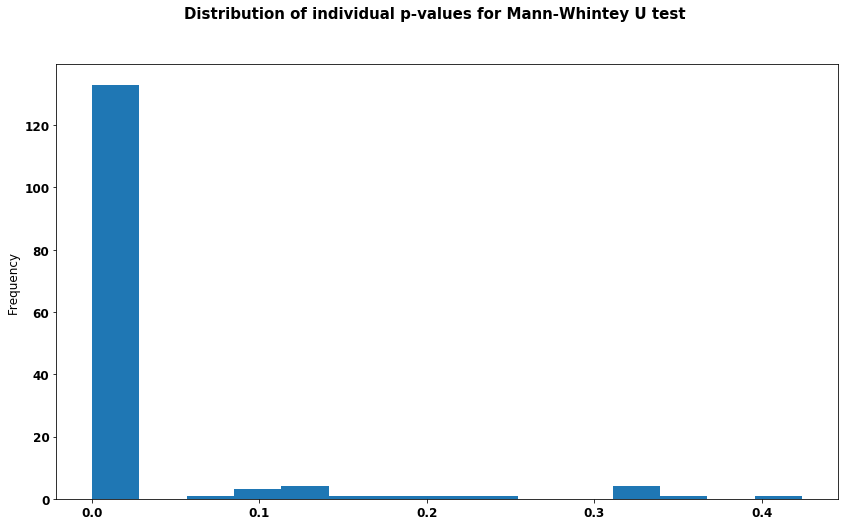

In [351]:
pd.Series([v for v in dic_mannwhitneyu.values()]).plot.hist(bins=15)
plt.suptitle("Distribution of individual p-values for Mann-Whintey U test",
             weight="bold",
            fontsize=15)

Text(0.5, 0.98, 'Distribution of individual p-values for Fisher association test')

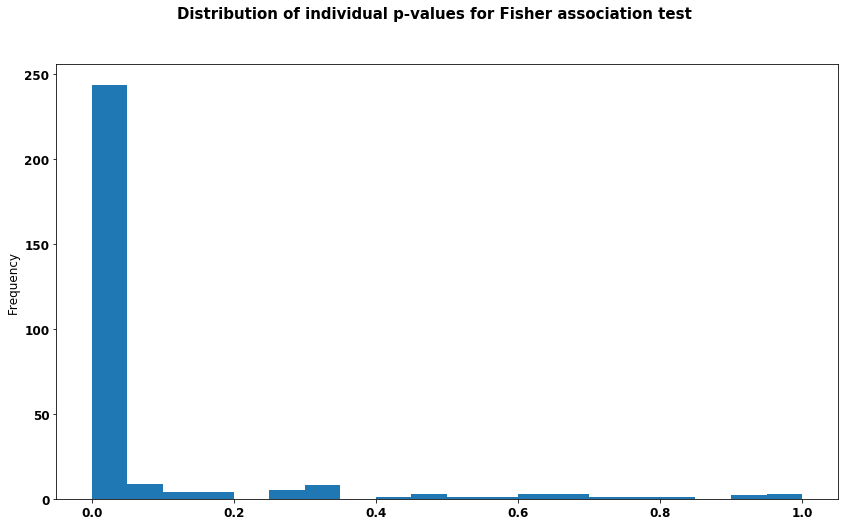

In [384]:
pd.Series([v for v in dic_fisher.values()]).plot.hist(bins=20)
plt.suptitle("Distribution of individual p-values for Fisher association test", 
             size=30,
             weight="bold",
            fontsize=15)

#### Multiple hypotheses testing correction: Bonferroni Method

In order to handle the multiple comparison issue (increase in the probability to "discover" false statistical associations, because of the number of tests performed), we will use the Bonferroni correction method. Although many other multiple comparison exist, Bonferroni is the most straightforward to use, because it doesn't require assumptions about variables correlation. Other PheWAS analysis also use the False Discovery Rate controlling procedures ([see](https://en.wikipedia.org/wiki/False_discovery_rate)).

In a nutshell, Bonferonni allows to calculate a corrected "statistical significant threshold" according to the number of test performed. Every p-value below this threshold will be deemed statistically significant.

In [361]:
# Merging pvalues from different tests
dic_pvalues = {**dic_mannwhitneyu, **dic_fisher}
df_pvalues = pd.DataFrame.from_dict(dic_pvalues, orient="index", columns=["pvalues"])\
.rename_axis("dummies_varName")\
.reset_index(drop=False)

# Adding pvalues results as a new column to variablesDict
variablesDict = joining_variablesTable_onCol(variablesDict,
                                              df_pvalues,
                                              left_col="dummies_varName",
                                              right_col="dummies_varName")

In [356]:
adjusted_alpha = 0.05/len(variablesDict["pvalues"])
variablesDict["p_adj"] = variablesDict["pvalues"] / len(variablesDict["pvalues"])

In [359]:
variablesDict["pvalues"]

level_0                        level_1              level_2                  level_3  level_4
00 Affection status            NaN                  NaN                      NaN      NaN         0.000000e+00
                                                                                      NaN         1.046690e-06
                                                                                      NaN         1.555196e-33
00 Consent groups              NaN                  NaN                      NaN      NaN         1.756327e-13
01 Demographics                Age at enrollment    NaN                      NaN      NaN        1.537331e-182
                                                                                                     ...      
Sub-study ESP LungGO COPDGene  Sex                  NaN                      NaN      NaN                  NaN
                               Smoker               Current smoker baseline  NaN      NaN         2.766068e-14
                  

In [301]:
variablesDict['log_p'] = -np.log10(variablesDict['pvalues'])

/Users/Arnaud/miniconda3/envs/dbmi_jupyterhub/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [302]:
pd.set_option('expand_frame_repr', False)

In [303]:
variablesDict = variablesDict.sort_index()
variablesDict["group"] = variablesDict.reset_index(level=1)["level_1"].values

In [304]:
variablesDict.loc[:, ["log_p", "pvalues"]].sort_values(["log_p"], ascending=False)

p_adj  pvalues
level_0                       level_1                  level_2                   level_3               level_4                                                           
00 Affection status           NaN                      NaN                       NaN                   NaN                                                   inf      0.0
03 Clinical data              Respiratory disease form 01 Respiratory symptoms   16 Shortness of breat 16d Have to stop for breath after 100 yards on ...    inf      0.0
                              CT scan                  CT measurements           CT VIDA               Hu 15th percentile Exp CT VIDA                        inf      0.0
                                                                                                       Hu 15th percentile Insp CT VIDA                       inf      0.0
                                                                                                       Percent Emph Lower Lobes CT VIDA                      inf      0.0
...                                                                                                                                                          ...      ...
                              Respiratory disease form 04 Respiratory Conditions 07 COPD               01 Have you ever had COPD                             NaN      NaN
Sub-study ESP LungGO COPDGene ESP Cohort               NaN                       NaN                   NaN                                                   NaN      NaN
                              Race                     NaN                       NaN                   NaN                                                   NaN      NaN
                              Sex                      NaN                       NaN                   NaN                                                   NaN      NaN
                              T2Diabetes baseline      NaN                       NaN                   NaN                                                   NaN      NaN

[461 rows x 2 columns]

### Manatthan plot

The classical synthetic data visualisation of a PheWAS analysis is the Manatthan plot, which plot each one of the tested phenotypes on the X-axis, against -log of pvalues on the Y types. Usually a horizontal line is drawn to represent the corrected level of significance calculated using an adequate multiple hypothesis correction method.

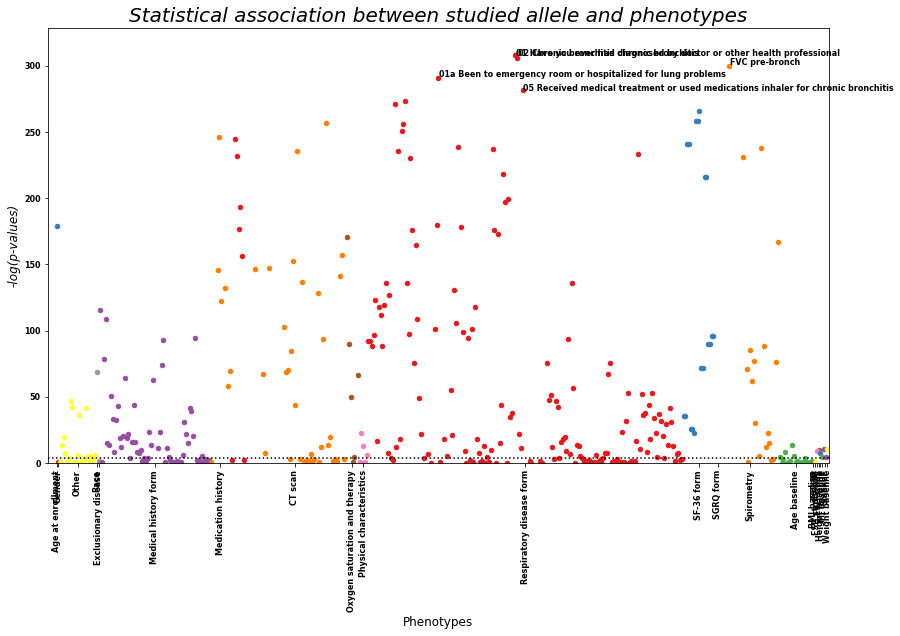

In [382]:
mask = variablesDict["pvalues"].isna()
df_results = variablesDict.loc[~mask,:].copy().replace([np.inf, -np.inf], np.nan)
df_results["ind"] = np.arange(1, len(df_results)+1)
df_grouped = df_results.groupby(('group'))

# print(df_grouped.head(10))

fig = plt.figure()
ax = fig.add_subplot(111)
colors = plt.get_cmap('Set1')
x_labels = []
x_labels_pos = []

y_lims = (0,
          df_results["p_adj"].max(skipna=True) + 20)
threshold_top_values = df_results["p_adj"].sort_values(ascending=False)[0:6][-1]

for num, (name, group) in enumerate(df_grouped):
        group.plot(kind='scatter', x='ind', y='p_adj',color=colors.colors[num % len(colors.colors)], ax=ax, s=20)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2)) # Set label in the middle
        
        pair_ind = 0 # To shift label which might overlap because to close
        for n, row in group.iterrows():
            if pair_ind %2 == 0:
                shift = 1.1
            else:
                shift = -1.1
            if row["p_adj"] > threshold_top_values:
                ax.text(row['ind'] + 0.2, row["p_adj"] + 0.05 + shift, row["simplified_varName"], rotation=0, alpha=1, size=8, color="black")
                pair_ind += 1
                
ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)
ax.set_xlim([0, len(df_results) +1])
ax.set_ylim(y_lims)
ax.set_ylabel('-log(p-values)', style="italic")
ax.set_xlabel('Phenotypes')
ax.axhline(y=-np.log10(adjusted_alpha), linestyle=":", color="black")
plt.xticks(fontsize = 8,rotation=90)
plt.yticks(fontsize = 8)
plt.title("Statistical association between studied allele and phenotypes", 
          loc="center",
          style="oblique", 
          fontsize = 20,
         y=1)
xticks = ax.xaxis.get_major_ticks()
xticks[0].set_visible(False)

plt.show()

In [51]:
now = datetime.now()
elapsed = now - then
print(elapsed)

0:04:03.554021
